# 0 Packages and Data Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Stats and other tools
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import scipy.stats as stats
import time
import logging
logging.getLogger().setLevel(logging.INFO)

#Models we will test and try
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import tensorflow as tf
import tensorflow.contrib.learn as learn

#Tensorflow abstractions (for when if we decide for a proper DNN implementation)
from tensorflow import estimator
#from keras import layers
#from tensorflow.contrib.layers import fully_connected

#from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
#from hyperas.distributions import choice, uniform, conditional
#from hyperas import optim
#from hyperopt import Trials, STATUS_OK, tpe


cv_k_global = 7 #the amount of f_folds to be used in all CV




train_full= pd.read_csv('train.csv')

quantitative = [f for f in train_full.columns if train_full.dtypes[f] != 'object']
quantitative.remove('Survived')#Survived is target label
quantitative.remove('PassengerId')#PassengerId will be turned into index
qualitative = [f for f in train_full.columns if train_full.dtypes[f] == 'object']

Using TensorFlow backend.


# 1. Exploratory Data Analysis

In [2]:
train_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Clearly PassengerId is better suited as the index of the DataFrame

In [4]:
train_full.set_index('PassengerId',inplace=True)

## 1.1 Preamble

There are a few things we expect from the data. For example, we know that higher class tickets were sorted to higher level decks, with easier access to life boats, therefore we expect first class to be a relevant feature to assess survival chance. Then, we expect children and women to take priority, as it is customary in popular culture that "women and children first" in emergency cases. This also means that there should some level of relation between survival chance and number of family members on board, as families would have taken prioriy in principal. Obviously, these are subjective expectations, and we will see if they hold.

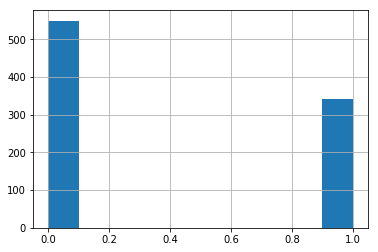

In [5]:
train_full['Survived'].hist()

In [6]:
train_full['Survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

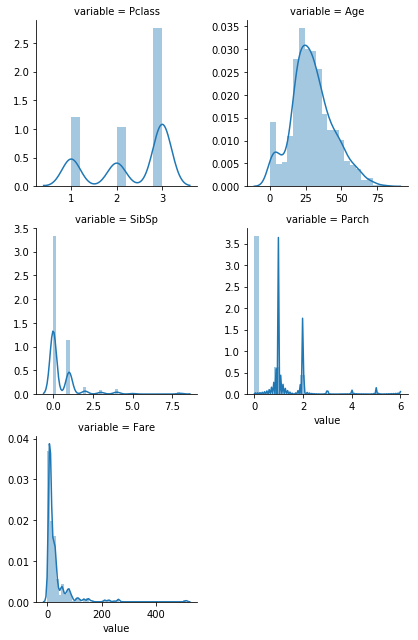

In [7]:
f = pd.melt(train_full, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

## 1.2 Target Class Analysis

We want to see how the target label/class is influenced by the features

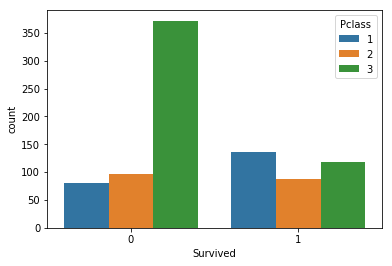

In [8]:
sns.countplot(x='Survived',hue='Pclass',data=train_full)

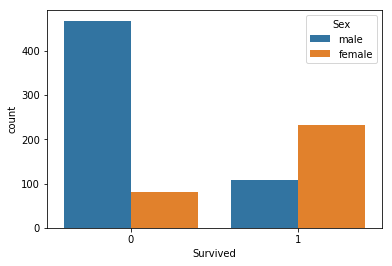

In [9]:
sns.countplot(x='Survived',hue='Sex',data=train_full)

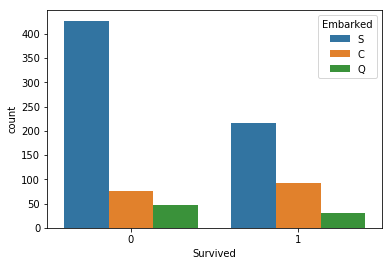

In [10]:
sns.countplot(x='Survived',hue='Embarked',data=train_full)

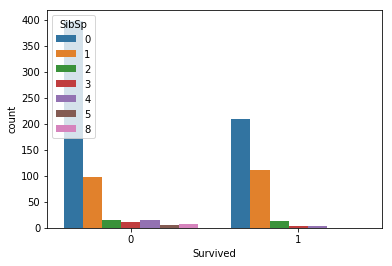

In [11]:
sns.countplot(x='Survived',hue='SibSp',data=train_full)

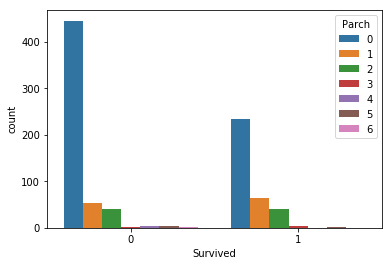

In [12]:
sns.countplot(x='Survived',hue='Parch',data=train_full)

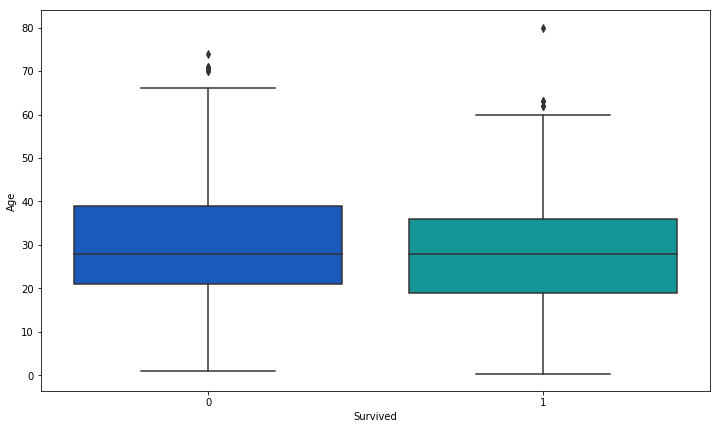

In [13]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Survived',y='Age',data=train_full,palette='winter')

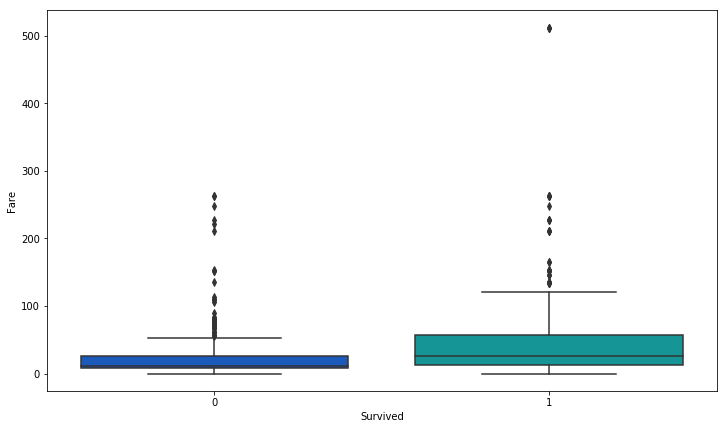

In [14]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Survived',y='Fare',data=train_full,palette='winter')

From the above we can outline some trends on the segments more likely to survive:
* First Class
* Women
* Age mostly similar, with a slight shift to younger people being more likely to have survived
* In proportion, people embarking in S were more likely to not have survived
* Higher fares
* In  proportion, people with family members seemd to have been more likely to have survived


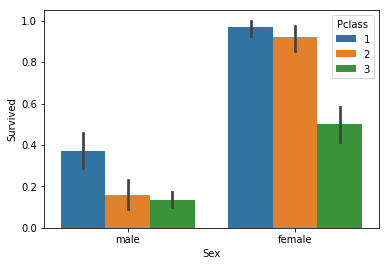

In [15]:
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=train_full)

With the above plot we confirm some of the previous points. Namely, First class males were at least twice as likely to have survived in comparisson with other classes, but women in second class enjoied a greater change of survivel. We also note that thrid class women were more likely to have survived than first class man.

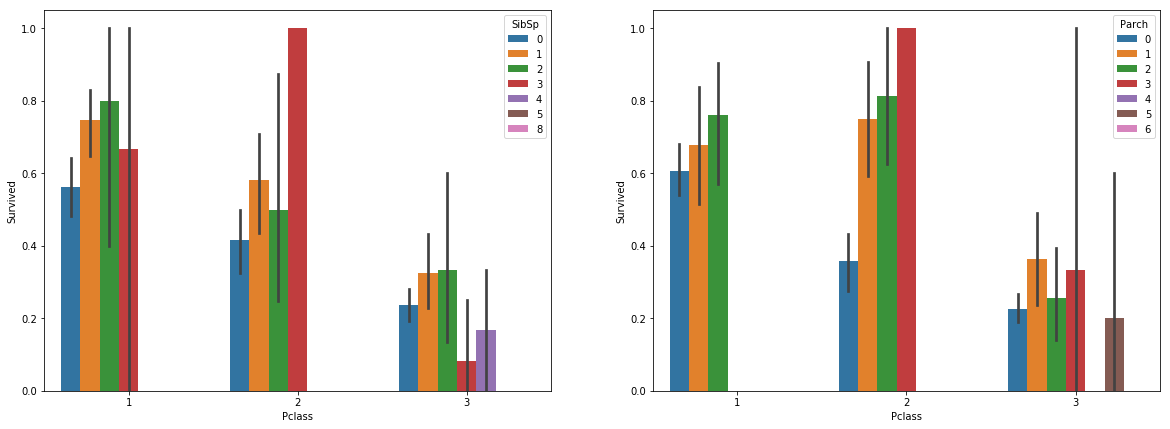

In [16]:
plt.figure(figsize=(20, 7))
plt.subplot(1,2,1)
sns.barplot(x="Pclass", y="Survived", hue="SibSp", data=train_full)
plt.subplot(1,2,2)
sns.barplot(x="Pclass", y="Survived", hue="Parch", data=train_full)

The two plots above show yet another tendency, which was to favour people with family on board . Notice that for each class, the chance of being saved if having family on board is greater than without.This might indicate that surnames might be relevant!

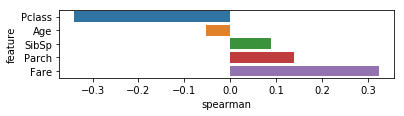

In [17]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['Survived'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative
spearman(train_full, features)

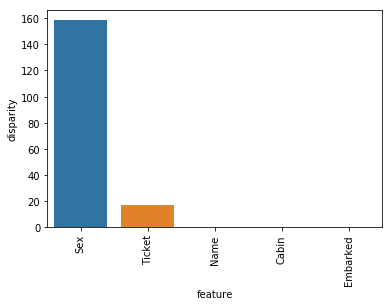

In [18]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():#for each level of the category c
            s = frame[frame[c] == cls]['Survived'].values
            samples.append(s)#Get all the values of SalePrice for the level cls of the categorical variable c, and append
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train_full)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

## 1.3 Feature Relations Analysis

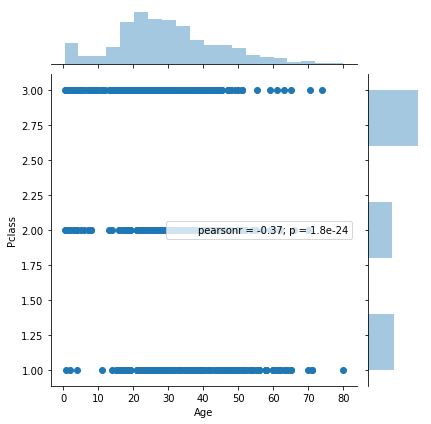

In [19]:
sns.jointplot(train_full['Age'],train_full['Pclass'])

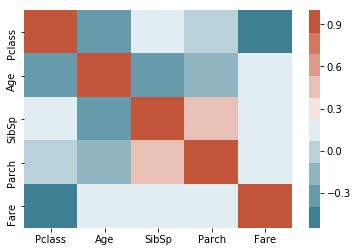

In [20]:
sns.heatmap(train_full.drop('Survived',axis=1).corr(),cmap=sns.diverging_palette(220, 20, n=10))

Some variables are fairly correlated:
* SibSp with Parch, possibly indicating presence of families.
* Pclass and Fare (negative), indicating first class was more expensive, as expected
* Age (negatively) correlated with Pclass (older people tended to be in first class), SibSp and Parch, meaning the older people seemed to not being with their families

## 1.4 Treating and Cleaning the Data

### 1.4.1 Finding and solving missing values

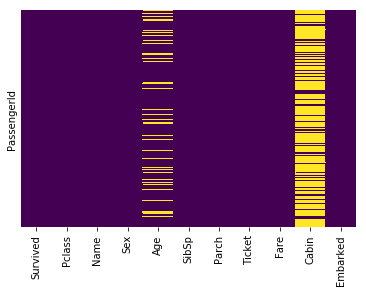

In [21]:
sns.heatmap(train_full.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [22]:
def missing_plot_and_count(data):
    missing = data.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
    print(missing)

Embarked      2
Age         177
Cabin       687
dtype: int64


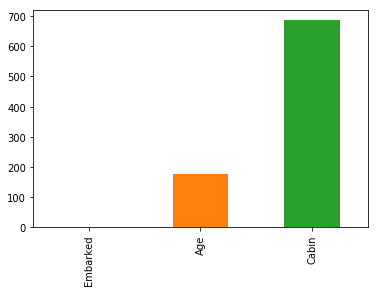

In [23]:
missing_plot_and_count(train_full)

How to treat the above missing values:
* Embarked is only missing into two observations, remove the observations.
* Age is missing in 20% of the observations, we will replace the missing values with the average age
* Cabin is missing in almost 80% of the observations, remove the feature

We might want to revisit some of these assumptions if we do not like the performance of our model. For example, the cabin number has information of the deck. Higher decks were closer to the life boats, therefore there would be a relation. Etc. But for now we are trying to fit a simplified model to the good data.

### 1.4.2 Removing null embark entries

In [24]:
train_full[train_full['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [25]:
train_full=train_full[train_full['Embarked'].notna()]

### 1.4.3 Filling in the missing age

Before continuing, let's see how Age is distributed between different segments of the data

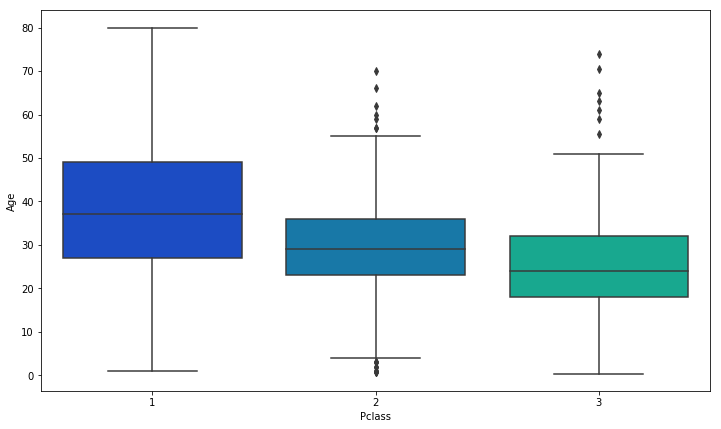

In [26]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train_full,palette='winter')

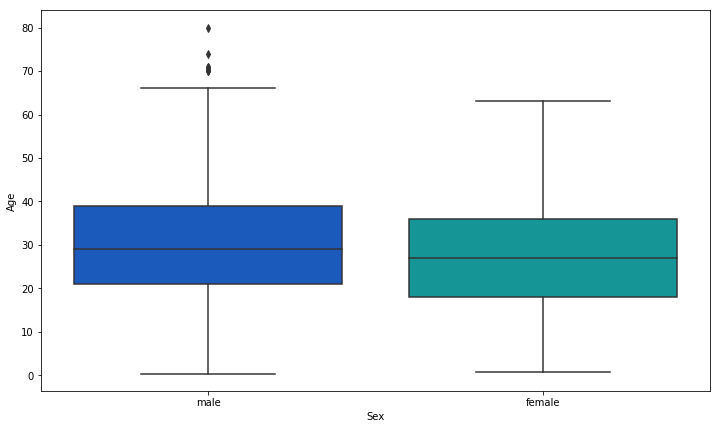

In [27]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Sex',y='Age',data=train_full,palette='winter')

It's evident that each Passenger Class has a distincit Age distribution, therefore we should average out the ages by Passenger Class

In [28]:
int(np.round(train_full[train_full['Pclass']==1]['Age'].mean()))

38

In [29]:
int(np.round(train_full[train_full['Pclass']==2]['Age'].mean()))

30

In [30]:
int(np.round(train_full[train_full['Pclass']==3]['Age'].mean()))

25

In [31]:
def clean_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 38

        elif Pclass == 2:
            return 30

        else:
            return 25

    else:
        return Age

In [32]:
train_full['Age'] = train_full[['Age','Pclass']].apply(clean_age,axis=1)

### 1.4.4 Removing cabin feature

In [33]:
train_full.drop('Cabin',inplace=True,axis=1)

###### And finally checking everythin is fine

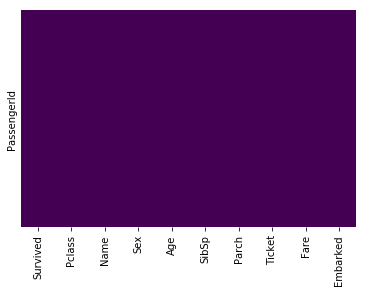

In [34]:
sns.heatmap(train_full.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [35]:
#missing_plot_and_count(train_full)

No more missing values! We can proceed.

## 1.5 One-hot enconding and Dummy variables

We need to turn Sex and Embarked into dummy variables. We also need to decide what to do with Age,Pclass, SibSp, Parch variables, if we should one-hot encode them or consider as continuous variables. For the time being, we will retain all as continuous, as there is some meaning in the distance between the levels of each. For example, first and third class had different accesses, how big was a family, etc

In [36]:
sex = pd.get_dummies(train_full['Sex'],drop_first=True)
embark = pd.get_dummies(train_full['Embarked'],drop_first=True)

In [37]:
train_full = pd.concat([train_full.drop(['Sex','Embarked'],axis=1),sex,embark],axis=1)
train_full.head()

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,male,Q,S
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,1
5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,1


###### About names and tickets

For the first attempt, we will ignore them. Later we will try to extract some information from these variables (for example, titles, ticket number, etc)

In [38]:
train_trimmed = train_full.drop(['Name','Ticket'],axis=1)

In [39]:
train_trimmed.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1
2,1,1,38.0,1,0,71.2833,0,0,0
3,1,3,26.0,0,0,7.9250,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1
5,0,3,35.0,0,0,8.0500,1,0,1


In [40]:
train_trimmed[train_trimmed['Fare']==0]

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
PassengerId,,,,,,,,,
180,0,3,36.0,0,0,0.0,1,0,1
264,0,1,40.0,0,0,0.0,1,0,1
272,1,3,25.0,0,0,0.0,1,0,1
278,0,2,30.0,0,0,0.0,1,0,1
303,0,3,19.0,0,0,0.0,1,0,1
414,0,2,30.0,0,0,0.0,1,0,1
467,0,2,30.0,0,0,0.0,1,0,1
482,0,2,30.0,0,0,0.0,1,0,1
598,0,3,49.0,0,0,0.0,1,0,1


All from Southampton. The crew members were from Southampton, which makes me wonder if these are the crew members.

In [41]:
train_trimmed['PaidFare']=train_trimmed['Fare'].apply(lambda x: 1 if x>0 else 0)#we want to keep track who hasn't paid

In [42]:
train_trimmed['Fare'].describe()

count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [43]:
train_trimmed['FareBin']=pd.cut(train_trimmed['Fare'],bins=[50*x for x in range(12)])

In [44]:
train_trimmed['Age'].describe()

count    889.000000
mean      29.218414
std       13.178017
min        0.420000
25%       22.000000
50%       26.000000
75%       36.500000
max       80.000000
Name: Age, dtype: float64

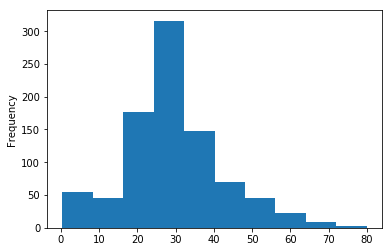

In [45]:
train_trimmed['Age'].plot('hist')

### 1.5.1 Going a bit too far with bins and dummies

We will bin and dummy all numericals. The purpose is to get each observation as an array of 0 and 1, avoiding the need for transformations etc. This is mostly an exploratory task, as there is meaning in the differences between levels in these variables.

In [46]:
train_trimmed['AgeBin']=pd.cut(train_trimmed['Age'],bins=[10*x for x in range(10)])

In [47]:
train_trimmed['HasSibSp']=train_trimmed['SibSp'].apply(lambda x: 1 if x>0 else 0)#we want to keep track who has SibSp

In [48]:
train_trimmed['HasParch']=train_trimmed['Parch'].apply(lambda x: 1 if x>0 else 0)#we want to keep track who has Parch

In [49]:
train_trimmed.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,PaidFare,FareBin,AgeBin,HasSibSp,HasParch
PassengerId,,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1,1,"(0, 50]","(20, 30]",1,0
2,1,1,38.0,1,0,71.2833,0,0,0,1,"(50, 100]","(30, 40]",1,0
3,1,3,26.0,0,0,7.9250,0,0,1,1,"(0, 50]","(20, 30]",0,0
4,1,1,35.0,1,0,53.1000,0,0,1,1,"(50, 100]","(30, 40]",1,0
5,0,3,35.0,0,0,8.0500,1,0,1,1,"(0, 50]","(30, 40]",0,0


In [50]:
pclass = pd.get_dummies(train_trimmed['Pclass'],drop_first=True)
agebin = pd.get_dummies(train_trimmed['AgeBin'],drop_first=True)
farebin = pd.get_dummies(train_trimmed['FareBin'],drop_first=True)
sibsp = pd.get_dummies(train_trimmed['SibSp'],drop_first=True)
parch = pd.get_dummies(train_trimmed['Parch'],drop_first=True)

In [51]:
train_trimmed_alldummied = pd.concat([train_trimmed.drop(['Pclass','Age','AgeBin','Fare','FareBin','SibSp','HasSibSp','Parch','HasParch'],axis=1),pclass,agebin,farebin,sibsp,parch],axis=1)
train_trimmed_alldummied.head()

,Survived,male,Q,S,PaidFare,2,3,"(10, 20]","(20, 30]","(30, 40]",...,3,4,5,8,1,2,3,4,5,6
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
survived_dummied = train_trimmed_alldummied[train_trimmed_alldummied['Survived']==1]
died_dummied = train_trimmed_alldummied[train_trimmed_alldummied['Survived']==0]

In [53]:
survived_average_matrix=survived_dummied.drop('Survived',axis=1).mean().values.reshape(6,6)
died_average_matrix=died_dummied.drop('Survived',axis=1).mean().values.reshape(6,6)

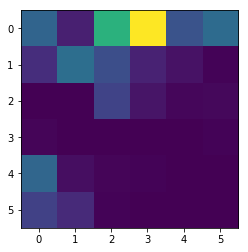

In [54]:
plt.imshow(survived_average_matrix)
plt.show()

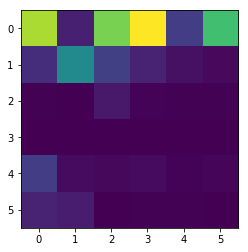

In [55]:
plt.imshow(died_average_matrix)
plt.show()

## 1.6 Distribution Assumptions and Variable Transformation

In [56]:
train_trimmed.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,PaidFare,FareBin,AgeBin,HasSibSp,HasParch
PassengerId,,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1,1,"(0, 50]","(20, 30]",1,0
2,1,1,38.0,1,0,71.2833,0,0,0,1,"(50, 100]","(30, 40]",1,0
3,1,3,26.0,0,0,7.9250,0,0,1,1,"(0, 50]","(20, 30]",0,0
4,1,1,35.0,1,0,53.1000,0,0,1,1,"(50, 100]","(30, 40]",1,0
5,0,3,35.0,0,0,8.0500,1,0,1,1,"(0, 50]","(30, 40]",0,0


Let's see if any of the numerical features is normally distributed

In [57]:
train_trimmed[quantitative].apply(lambda x: stats.normaltest(x.fillna(x.fillna(x.mean())))[1]> 0.01)

Pclass    False
Age       False
SibSp     False
Parch     False
Fare      False
dtype: bool

Graphically

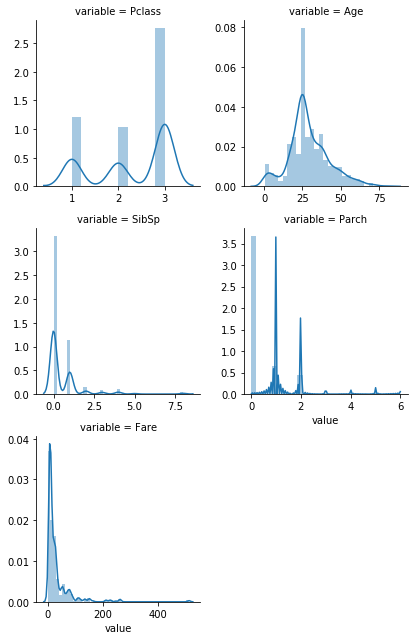

In [58]:
f = pd.melt(train_trimmed, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

It's starting get more and more clear that Pclass should not be treated as a numerical variable.

In [59]:
train_trimmed[quantitative].skew()

Pclass   -0.636998
Age       0.512581
SibSp     3.691058
Parch     2.745160
Fare      4.801440
dtype: float64

SipSp, Parch, and Fare are skewed. For which we will log transform. Not, however, that all of them have many entries equalying zero.

In [60]:
def logtransform(data):
    return np.log10(data+1)#+1 avoids issues with vanishing entries by shifting the log function to the left by 1

In [61]:
train_trimmed[['SibSp','Parch','Fare']].apply(logtransform).skew()

SibSp    1.657860
Parch    1.671905
Fare     0.400109
dtype: float64

Slightly better, we'll use this.

Let's try to normalise the age variable.

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_trimmed['Age'].values.reshape(-1,1))
agestandard=pd.DataFrame(scaler.transform(train_trimmed['Age'].values.reshape(-1,1)),index=train_trimmed.index,columns=['AgeStandard'])
print(agestandard.apply(lambda x: stats.normaltest(x.fillna(x.fillna(x.mean())))[1]> 0.01))
print(agestandard.apply(lambda x: stats.normaltest(x.fillna(x.fillna(x.mean())))[1]))

AgeStandard    False
dtype: bool
AgeStandard    2.556886e-11
dtype: float64


In [63]:
from sklearn.preprocessing import quantile_transform
temp=quantile_transform(train_trimmed['Age'].values.reshape(-1,1),output_distribution='normal',n_quantiles=25,copy=True)
agestandard=pd.DataFrame(temp,index=train_trimmed.index,columns=['AgeStandard'],copy=True)
print(agestandard.apply(lambda x: stats.normaltest(x.fillna(x.fillna(x.mean())))[1]> 0.01))
print(agestandard.apply(lambda x: stats.normaltest(x.fillna(x.fillna(x.mean())))[1]))

AgeStandard    False
dtype: bool
AgeStandard    0.000019
dtype: float64


Unsuccseful in normalising the age data, but the above transform seems to get as close as possible, still with a fairly small p-value in our normality test

In [64]:
train_trimmed['AgeScaled']=agestandard
train_trimmed['FareScaled']=train_trimmed['Fare'].apply(logtransform)
train_trimmed['SibSpScaled']=train_trimmed['SibSp'].apply(logtransform)
train_trimmed['ParchScaled']=train_trimmed['Parch'].apply(logtransform)

In [65]:
train_trimmed.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,PaidFare,FareBin,AgeBin,HasSibSp,HasParch,AgeScaled,FareScaled,SibSpScaled,ParchScaled
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1,1,"(0, 50]","(20, 30]",1,0,-0.674490,0.916454,0.30103,0.0
2,1,1,38.0,1,0,71.2833,0,0,0,1,"(50, 100]","(30, 40]",1,0,0.812218,1.859038,0.30103,0.0
3,1,3,26.0,0,0,7.9250,0,0,1,1,"(0, 50]","(20, 30]",0,0,0.000000,0.950608,0.00000,0.0
4,1,1,35.0,1,0,53.1000,0,0,1,1,"(50, 100]","(30, 40]",1,0,0.548522,1.733197,0.30103,0.0
5,0,3,35.0,0,0,8.0500,1,0,1,1,"(0, 50]","(30, 40]",0,0,0.548522,0.956649,0.00000,0.0


In [66]:
train_trimmed_scalled=train_trimmed.drop(['Age','Fare','SibSp','Parch','PaidFare','FareBin','AgeBin','HasSibSp','HasParch'],axis=1)

In [67]:
train_trimmed_scalled.head()

,Survived,Pclass,male,Q,S,AgeScaled,FareScaled,SibSpScaled,ParchScaled
PassengerId,,,,,,,,,
1,0,3,1,0,1,-0.674490,0.916454,0.30103,0.0
2,1,1,0,0,0,0.812218,1.859038,0.30103,0.0
3,1,3,0,0,1,0.000000,0.950608,0.00000,0.0
4,1,1,0,0,1,0.548522,1.733197,0.30103,0.0
5,0,3,1,0,1,0.548522,0.956649,0.00000,0.0


## 1.7 Surnames, titles, and ticket info

In [68]:
tickets=train_full['Ticket']

In [69]:
names=train_full['Name']

In [70]:
surnames=names.apply(lambda name: name.split(',',1)[0].split()[0] if name.split(',',1)[0].split()[0]!='van' else name.split(',',1)[0].split()[1])

In [71]:
#names.apply(lambda name: name.split(',',1)[0].split()[0]).duplicated()

In [72]:
duplicated_surnames_tickets=train_full[['Name','Ticket']]

In [73]:
duplicated_surnames_tickets['DuplicatedName']=duplicated_surnames_tickets['Name'].apply(lambda name: name.split(',',1)[0].split()[0]).duplicated()

In [74]:
duplicated_surnames_tickets['DuplicatedTicket']=duplicated_surnames_tickets['Ticket'].duplicated()

In [75]:
#(train_full['SibSp']>0) | (train_full['Parch']>0)

In [76]:
duplicated_surnames_tickets['HasFamily']=(train_full['SibSp']>0) | (train_full['Parch']>0)

In [77]:
duplicated_surnames_tickets

,Name,Ticket,DuplicatedName,DuplicatedTicket,HasFamily
PassengerId,,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,False,False,True
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,False,False,True
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,False,False,False
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,False,False,True
5,"Allen, Mr. William Henry",373450,False,False,False
6,"Moran, Mr. James",330877,False,False,False
7,"McCarthy, Mr. Timothy J",17463,False,False,False
8,"Palsson, Master. Gosta Leonard",349909,False,False,True
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",347742,False,False,True


In [78]:
duplicated_surnames_tickets['DuplicatedName']=duplicated_surnames_tickets['DuplicatedName'].apply(lambda x: 1 if x else 0)
duplicated_surnames_tickets['DuplicatedTicket']=duplicated_surnames_tickets['DuplicatedTicket'].apply(lambda x: 1 if x else 0)
duplicated_surnames_tickets['HasFamily']=duplicated_surnames_tickets['HasFamily'].apply(lambda x: 1 if x else 0)

In [79]:
duplicated_surnames_tickets['Surname']=duplicated_surnames_tickets['Name'].apply(lambda name: name.split(',',1)[0].split()[0])

In [80]:
duplicated_surnames_tickets['Surname']='Unique'
is_duplicated = (duplicated_surnames_tickets['DuplicatedName']==1)
duplicated_surnames_tickets.loc[is_duplicated,'Surname'] = surnames

In [81]:
duplicated_surnames_tickets['Tickets']='Unique'
is_duplicated = (duplicated_surnames_tickets['DuplicatedTicket']==1)
duplicated_surnames_tickets.loc[is_duplicated,'Tickets'] = tickets

In [82]:
duplicated_surnames_tickets

,Name,Ticket,DuplicatedName,DuplicatedTicket,HasFamily,Surname,Tickets
PassengerId,,,,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,0,0,1,Unique,Unique
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,0,0,1,Unique,Unique
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,0,0,0,Unique,Unique
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,0,0,1,Unique,Unique
5,"Allen, Mr. William Henry",373450,0,0,0,Unique,Unique
6,"Moran, Mr. James",330877,0,0,0,Unique,Unique
7,"McCarthy, Mr. Timothy J",17463,0,0,0,Unique,Unique
8,"Palsson, Master. Gosta Leonard",349909,0,0,1,Unique,Unique
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",347742,0,0,1,Unique,Unique


In [83]:
surname_dummies=pd.get_dummies(duplicated_surnames_tickets['Surname'],drop_first=True)
tickets_dummies=pd.get_dummies(duplicated_surnames_tickets['Tickets'],drop_first=True)
duplicated_surnames_tickets_full=pd.concat([duplicated_surnames_tickets,surname_dummies,tickets_dummies],axis=1)

In [84]:
duplicated_surnames_tickets_full.head()

,Name,Ticket,DuplicatedName,DuplicatedTicket,HasFamily,Surname,Tickets,Abelson,Ali,Allen,...,PP 9549,S.C./PARIS 2079,S.O./P.P. 3,S.O.C. 14879,SC/Paris 2123,STON/O2. 3101279,Unique,W./C. 6607,W./C. 6608,WE/P 5735
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,0,0,1,Unique,Unique,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,0,0,1,Unique,Unique,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,0,0,0,Unique,Unique,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,0,0,1,Unique,Unique,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,"Allen, Mr. William Henry",373450,0,0,0,Unique,Unique,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [85]:
train_trimmed_scalled_2=pd.concat([train_trimmed_scalled,duplicated_surnames_tickets_full[['DuplicatedName','DuplicatedTicket','HasFamily']]],axis=1)

In [86]:
train_trimmed_scalled_2.head()

,Survived,Pclass,male,Q,S,AgeScaled,FareScaled,SibSpScaled,ParchScaled,DuplicatedName,DuplicatedTicket,HasFamily
PassengerId,,,,,,,,,,,,
1,0,3,1,0,1,-0.674490,0.916454,0.30103,0.0,0,0,1
2,1,1,0,0,0,0.812218,1.859038,0.30103,0.0,0,0,1
3,1,3,0,0,1,0.000000,0.950608,0.00000,0.0,0,0,0
4,1,1,0,0,1,0.548522,1.733197,0.30103,0.0,0,0,1
5,0,3,1,0,1,0.548522,0.956649,0.00000,0.0,0,0,0


In [87]:
train_trimmed_scalled_3=pd.concat([train_trimmed_scalled,duplicated_surnames_tickets_full.drop(['Name','Ticket','DuplicatedName','DuplicatedTicket','HasFamily','Surname','Tickets'],axis=1)],axis=1)

In [88]:
train_trimmed_scalled_3.head()

,Survived,Pclass,male,Q,S,AgeScaled,FareScaled,SibSpScaled,ParchScaled,Abelson,...,PP 9549,S.C./PARIS 2079,S.O./P.P. 3,S.O.C. 14879,SC/Paris 2123,STON/O2. 3101279,Unique,W./C. 6607,W./C. 6608,WE/P 5735
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,1,0,1,-0.674490,0.916454,0.30103,0.0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,0,0,0,0.812218,1.859038,0.30103,0.0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,3,0,0,1,0.000000,0.950608,0.00000,0.0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,1,0,0,1,0.548522,1.733197,0.30103,0.0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,3,1,0,1,0.548522,0.956649,0.00000,0.0,0,...,0,0,0,0,0,0,1,0,0,0


## 1.8 A few more inferences using the treated data (Anova and Spearman)

In [3]:
data_1 = pd.read_csv('data_train_1.csv')
data_2 = pd.read_csv('data_train_2.csv')
data_3 = pd.read_csv('data_train_3.csv')

In [4]:
data_1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'AgeStandard', 'FareStandard',
       'SibSp', 'Parch', 'male', 'Q', 'S', 'B', 'C', 'D', 'E', 'F', 'G', 'T'],
      dtype='object')

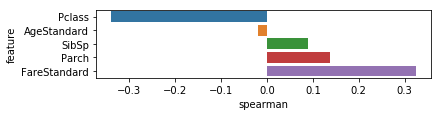

In [5]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['Survived'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = ['Pclass', 'AgeStandard', 'FareStandard','SibSp', 'Parch']
spearman(data_1, features)

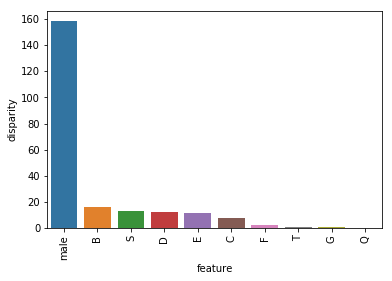

In [8]:
def anova(frame, features):
    anv = pd.DataFrame()
    anv['feature'] = features
    pvals = []
    for c in features:
        samples = []
        for cls in frame[c].unique():#for each level of the category c
            s = frame[frame[c] == cls]['Survived'].values
            samples.append(s)#Get all the values of SalePrice for the level cls of the categorical variable c, and append
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

features
a = anova(data_1,[ 'male', 'Q', 'S', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

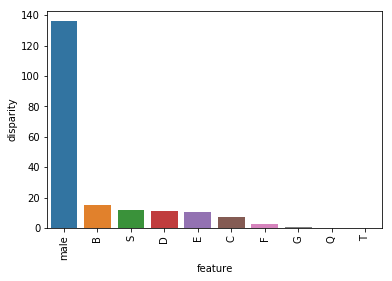

In [47]:
def pearson (data,features):
    pearson=pd.DataFrame()
    pearson['feature']=features
    pvals=[]
    for f in features:
        _,p =stats.fisher_exact(pd.crosstab(data['Survived'],data[f]))
        pvals.append(p)
    pearson['pval']=pvals
    return pearson.sort_values('pval')

a=pearson(data_1,[ 'male', 'Q', 'S', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

In [13]:
a = data_1['male']==0
b = data_1['B']==0
data_1.groupby([a,b]).count() 

PassengerId  Survived  Pclass  AgeStandard  FareStandard  SibSp  \
male  B                                                                        
False False           20        20      20           20            20     20   
      True           557       557     557          557           557    557   
True  False           27        27      27           27            27     27   
      True           287       287     287          287           287    287   

             Parch  male    Q    S    B    C    D    E    F    G    T  
male  B                                                                
False False     20    20   20   20   20   20   20   20   20   20   20  
      True     557   557  557  557  557  557  557  557  557  557  557  
True  False     27    27   27   27   27   27   27   27   27   27   27  
      True     287   287  287  287  287  287  287  287  287  287  287

In [14]:
pd.crosstab(data_1['male'],data_1['B'])

B,0,1
male,,
0,287,27
1,557,20


In [16]:
_,p =stats.fisher_exact(pd.crosstab(data_1['male'],data_1['B']))

In [20]:
allp=[]
for x  in [ 'male', 'Q', 'S', 'B', 'C', 'D', 'E', 'F', 'G', 'T']:
    row=[]
    for y in [ 'male', 'Q', 'S', 'B', 'C', 'D', 'E', 'F', 'G', 'T']:
        p=0
        _,p =stats.fisher_exact(pd.crosstab(data_1[x],data_1[y]))
        row.append(p)
    allp.append(row)

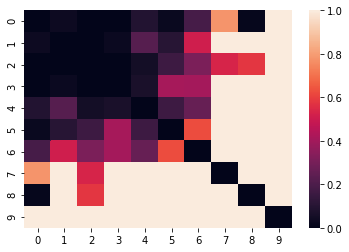

In [21]:
sns.heatmap(allp)